In [256]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import numpy as np


In [257]:
def synthetic_data(w, b, num_examples):
    # 这一步为什么这样写，因为我不会用那个torch.normal的方法，一直报错
    # update:torch版本问题，换成1.4版本就好了
    X = torch.normal( 0 ,1 ,( num_examples , len( w )))
    y = torch.matmul( X ,w ) + b 
    print( y.shape )
    #加入噪声
    y += torch.Tensor( np.random.normal( 0, 0.01 , y.shape ))
    return X , y.reshape( -1 , 1 )
    #y实际上输出了一个一维张量，但是我们在实际操作中是需要一个二维张量，这里reshape成一个1000*1的张量
    #这样的话每一行就对应一个标签了 

true_w = torch.Tensor([2,-3.4])
true_b = 4.2
features,labels =  synthetic_data( true_w ,true_b ,1000 )
features,labels


torch.Size([1000])


(tensor([[-0.8693,  0.2323],
         [ 1.2094, -0.1583],
         [-0.9035, -0.3785],
         ...,
         [-0.2712, -0.1664],
         [ 0.6947, -0.0200],
         [-0.8698, -0.6246]]),
 tensor([[ 1.6654],
         [ 7.1659],
         [ 3.6923],
         [ 1.5653],
         [ 4.9813],
         [ 6.9318],
         [ 6.4421],
         [ 3.8611],
         [ 3.3949],
         [-0.4331],
         [ 6.0585],
         [ 6.6944],
         [ 4.4047],
         [ 6.3536],
         [ 0.8500],
         [ 3.4450],
         [11.7049],
         [ 8.9668],
         [ 3.1448],
         [ 9.1489],
         [ 2.2059],
         [-0.3577],
         [ 3.9043],
         [ 0.1831],
         [ 5.5835],
         [ 0.3220],
         [ 2.7807],
         [ 5.5114],
         [ 3.7000],
         [ 6.3371],
         [11.0632],
         [ 6.9996],
         [ 1.7045],
         [-2.2693],
         [ 2.4841],
         [-1.0382],
         [ 9.9841],
         [ 5.9891],
         [ 7.7417],
         [ 2.0749],
         [

In [258]:
2*features[0][0] -3.4* features[0][1]+4.2 #数据建立正确

tensor(1.6716)

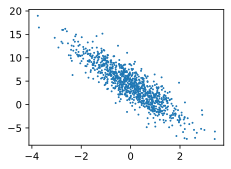

In [259]:
d2l.set_figsize()
#实际上这一步detach加得很没有必要，我们不需要进行梯度运算，这里有装逼的嫌疑
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [260]:
torch.normal(0, 0.01, size=(2,1), requires_grad=True)#这一段是1.1版本的，我就不删了

tensor([[-0.0028],
        [-0.0003]], requires_grad=True)

In [261]:
def data_iter( batch_size , features , labels ):
    num_examples = len( features )
    # print( num_examples)
    indics = list( range( num_examples ))
    random.shuffle( indics )#随机打乱这个存储指标的列表
    for i in range( 0 , num_examples , batch_size ):#以batch_size作为步长构造这个批次数据
        # 这一段就是想从indics数据中按照批次batch_size大小，取出打乱的下标数据，每一批次的下标数据都要转换为tensor变量
        # 才能对features和labels等tensor变量进行一个提取，因为list是没办法由list数据进行提取的，具体可参见scratch.ipynb
        batch_indics = torch.tensor( indics[i : min( i + batch_size , num_examples ) ] )
        yield features[batch_indics] , labels[batch_indics] #s现在就是一个生成器，惰性生成数据

In [262]:
batch_size = 10
# for data ,labels in data_iter( batch_size , features , labels ):
#     print( data , '\n',labels )
#     break

In [263]:
w = torch.normal( 0 , 0.01 , (2,1) ,requires_grad = True )#初始化参数，并让参数可用求梯度
b = torch.zeros( 1 , requires_grad= True) 
w,b

(tensor([[ 0.0019],
         [-0.0043]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [264]:
#模型设置
def linear_model( X , w , b):
    return torch.matmul( X , w )+b 

In [265]:
def loss( y_hat , y ):
    return (y_hat - y.reshape( y_hat.shape))**2 / 2 

In [266]:
def sgd( params , lr  , batch_size ):
    # with torch.no_grad():
    for param in params:
        param -= lr * param.grad  /batch_size#这里除掉一个batch_size的原因是因为在下面的loss函数中做了一次sum，也就是得到了一
        # 个批次数据的所有loss的总和，那么这样的话在做权值更新的时候，w,b要更新的值不可能把所有loss对w,b的微分作为一个步长，所以
        # 这里需要做一个batch——size的处理
        #那么更新完毕后，w,b作为全新的值，而这些参数存储的梯度也要做一个清零，不然w,b的梯度会累加
        #这里如果打印一下的话，会发现params的requires_grad仍然是True，即仍然在求梯度
        param.grad.zero_()

In [267]:
def sgd2( params , lr  , batch_size ):
    with torch.no_grad():
        for param in params:
            param -= param - lr * param.grad  /batch_size
            #这里如果打印一下的话，会发现params的requires_grad仍然是True，即仍然在求梯度,如果这样写的话就不是inplace操作了，那么
            # 这样的话就会造成param的requires_grad为False,grad_fn=None,梯度清零
            # print(  param.grad)

In [268]:
lr = 0.02 #超参数调整
epochs = 3
net = linear_model#选择一个模型
loss_func = loss
for epoch in range( epochs ):
    for data , label in  data_iter( batch_size , features , labels ):
        l  = loss_func( net( data , w , b) , label) 
        # print( w.requires_grad )
        l.sum().backward()
        sgd( [w , b ] , lr , batch_size )
    print(f'当前次数{epoch}   loss:{l.mean()}' )

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

In [ ]:
w,b